<a href="https://colab.research.google.com/github/blackhalo9/lotto_prediction/blob/main/NHITS_230227.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib

path = pathlib.Path.cwd()

In [ ]:
!pip install pytorch_lightning ray neuralforecast

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os, torch
os.chdir("/content/drive/MyDrive/NHITS")
print(os.getcwd())

/content/drive/MyDrive/NHITS


In [8]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from ray import tune
from sklearn.preprocessing import StandardScaler

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoTFT
from neuralforecast.models import NBEATS, NBEATSx, NHITS, TFT, LSTM
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, GMM, PMM
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MAE

## <기준날짜 및 예측 기간 설정>

In [9]:
cutoff_date = '2022-04-30' ## len = 65
test_period = 8  ## 예측 기간 (월)
corr_rate = 0.8 ## Lag corr rate
future_variable_limit = 3
hist_corr_rate = 0.7 ## Lag corr rate
hist_variable_limit = 3

## <원 data set>

In [10]:
df = pd.read_csv('./data/metal_pst.csv')
df.rename(columns={'date':'ds'},inplace=True)
df.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

# 스케일링
df_tgt = df.iloc[:,3:]
scaler = StandardScaler()
scaler.fit(df_tgt)
arr = scaler.transform(df_tgt)
df_tmp = pd.DataFrame(arr, columns=df_tgt.columns)
df = pd.concat([df.iloc[:,:3],df_tmp], axis=1)

raw_y_set_resampled = df.copy()
raw_y_set_resampled.rename(columns={'ds':'date'},inplace=True)
raw_y_set_resampled.rename(columns={'lioh_cif_fast_kg_spot_exchng':'y2'},inplace=True)
del raw_y_set_resampled['unique_id']

#### FFT

In [ ]:
# def FFT(df, col, topn=2):
#     fft = np.fft.fft(df[col])
#     fft[topn:-topn] = 0
#     ifft = np.fft.ifft(fft)
#     return ifft

# df['y'] = FFT(df, 'y', 40)

#### WAVELET

In [ ]:
# !pip install PyWavelets
# import pywt

# def WT(df, col, wavelet='db5', thresh=0.63):
#     signal = df['y'].values
#     thresh = thresh*np.nanmax(signal)
#     coeff = pywt.wavedec(signal, wavelet, mode="per" )
#     coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
#     reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
#     return reconstructed_signal

# df['y'] = WT(df, 'y', wavelet='db5', thresh=0.63)

## Feature shift

In [11]:
%%time

raw_y_set_resampled = raw_y_set_resampled[raw_y_set_resampled.date<=cutoff_date]
raw_y_set_shifted_merged = raw_y_set_resampled['date']

for i in range(len(raw_y_set_resampled.columns)):
    if i == len(raw_y_set_resampled.columns) - 1:
        break
    raw_y_set_shifted = raw_y_set_resampled.iloc[:,[0,i+1]].dropna()
    for j in range(test_period-1,test_period):
        raw_y_set_shifted = pd.concat([raw_y_set_shifted, (raw_y_set_shifted.iloc[:,1].shift(j+1).rename(raw_y_set_resampled.columns[i+1] + '_' +str(j+1)+ '_'))],axis=1)
        raw_y_set_shifted_merged = pd.merge(raw_y_set_shifted_merged, raw_y_set_shifted, how= 'outer') 
        if j == len(raw_y_set_shifted.iloc[:,1]) -2 :
            break
# raw_y_set_shifted_merged.to_csv('./data/raw_y_set_shifted_merged.csv', encoding='cp949')

CPU times: user 48 s, sys: 178 ms, total: 48.2 s
Wall time: 57 s


In [12]:
raw_y_set_shifted_merged

,date,y,y_8_,y2,y2_8_,Baltic Dry Index (BDI),Baltic Dry Index (BDI)_8_,Howe Robinson Container Index,Howe Robinson Container Index_8_,Shanghai Containerized Freight Index (SCFI),...,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_Open_8_,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_High_8_,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Low_8_,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Close_8_,Allkem Limited (AKE.AX)_price_Adj Close,Allkem Limited (AKE.AX)_price_Adj Close_8_
0,2016-01-31,20.177268,NaN,-0.237734,NaN,-1.302468,NaN,-0.644064,NaN,-0.195705,...,-0.915916,NaN,-0.911882,NaN,-0.921663,NaN,-0.909069,NaN,-0.909069,NaN
1,2016-02-29,23.306868,NaN,-0.054803,NaN,-1.396112,NaN,-0.645288,NaN,-0.182527,...,-0.910118,NaN,-0.915569,NaN,-0.908508,NaN,-0.916207,NaN,-0.916207,NaN
2,2016-03-31,25.223010,NaN,0.133909,NaN,-1.305967,NaN,-0.644523,NaN,-0.362815,...,-0.833402,NaN,-0.834459,NaN,-0.834589,NaN,-0.834453,NaN,-0.834453,NaN
3,2016-04-30,25.308243,NaN,0.173425,NaN,-1.041598,NaN,-0.648195,NaN,-0.472294,...,-0.691659,NaN,-0.695181,NaN,-0.693237,NaN,-0.700107,NaN,-0.700107,NaN
4,2016-05-31,24.875099,NaN,0.107095,NaN,-1.026945,NaN,-0.645747,NaN,-0.487834,...,-0.497700,NaN,-0.494779,NaN,-0.496022,NaN,-0.493870,NaN,-0.493870,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2021-12-31,33.043478,11.326087,0.286579,-0.652782,1.582281,1.161139,1.839908,0.215543,1.084157,...,1.185124,0.173441,1.187299,0.191123,1.189690,0.181815,1.197156,0.198840,1.197156,0.198840
72,2022-01-31,43.260870,12.727273,0.631414,-0.602008,0.318707,1.739329,1.983558,0.394838,1.463396,...,1.610945,0.343123,1.608097,0.341999,1.585530,0.337288,1.586450,0.341566,1.586450,0.341566
73,2022-02-28,56.425000,13.340909,1.270279,-0.544854,0.406105,1.700096,2.294724,0.652644,1.435042,...,1.168835,0.295629,1.174279,0.292393,1.163390,0.301950,1.167415,0.293123,1.167415,0.293123
74,2022-03-31,71.086957,14.045455,2.126927,-0.489898,1.148209,2.001985,2.612162,1.135170,1.241856,...,1.471655,0.519217,1.468981,0.524612,1.476677,0.536282,1.477051,0.534588,1.477051,0.534588


#### 해당 기간에서의 lag corr best

In [13]:
raw_y_set_shifted_merged_corr = raw_y_set_shifted_merged.corr()
raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_corr[raw_y_set_resampled.columns.drop('date')]
# raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y']
# raw_y_set_shifted_merged_filtered = raw_y_set_shifted_merged_filtered.loc[raw_y_set_shifted_merged_filtered.index != 'y2']
raw_y_set_shifted_merged_filtered_y = raw_y_set_shifted_merged_filtered.iloc[:,:1]
raw_y_set_shifted_merged_filtered_y['y'] = abs(raw_y_set_shifted_merged_filtered_y['y'])
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_y[raw_y_set_shifted_merged_filtered_y.y >= corr_rate]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[raw_y_set_shifted_merged_filtered_upto_corr_rate.index.str.contains(f'_{test_period}_')]
raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate[:future_variable_limit]

futr_list = raw_y_set_shifted_merged_filtered_upto_corr_rate.index.values.tolist()
futr_list = [word.replace(f"_{test_period}_", "") for word in futr_list]

# if 'li2co395_am_kg' in futr_list:
#     futr_list = [w.replace('li2co395_am_kg', 'li2co3_995_am_kg') for w in futr_list]
# raw_y_set_shifted_merged_filtered_upto_corr_rate = raw_y_set_shifted_merged_filtered_upto_corr_rate.sort_values('y',ascending=False)

# if 'y2' in futr_list:
#     (futr_list).remove('y2')
# if 'li2co395_am_kg' in futr_list:
#     (futr_list).remove('li2co395_am_kg')
# if 'li2co3_995_am_kg' in futr_list:
#     (futr_list).remove('li2co3_995_am_kg')
# if 'mn_mb_kg' in futr_list:
#     (futr_list).remove('mn_mb_kg')
# if 'al_lme_kg' in futr_list:
#     (futr_list).remove('al_lme_kg')

futr_list

['Howe Robinson Container Index', 'mn_mb_kg', 'CCI_SWE']

#### 해당 기간에서의 corr best

In [14]:
hist_variable_limit

3

In [15]:
hist_var_chcek = raw_y_set_resampled.iloc[:,1:]

hist_var_corr = hist_var_chcek.corr()
hist_var_corr_filtered = hist_var_corr.loc[hist_var_corr.index != 'y']
hist_var_corr_filtered = hist_var_corr_filtered.loc[hist_var_corr_filtered.index != 'y2']
hist_var_corr_filtered_y = hist_var_corr_filtered.iloc[:,:1]
hist_var_corr_filtered_y['y'] = abs(hist_var_corr_filtered_y['y'])
hist_var_corr_filtered_y_corr_rate = hist_var_corr_filtered_y[hist_var_corr_filtered_y.y >= hist_corr_rate]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_corr_rate[hist_var_corr_filtered_y_corr_rate.index.str.contains('li2co3')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only[hist_var_corr_filtered_y_only.index.str.contains('lioh')==False]
hist_var_corr_filtered_y_only = hist_var_corr_filtered_y_only.sort_values('y',ascending=False)
hist_var_list = hist_var_corr_filtered_y_only.index.values.tolist()

hist_list = hist_var_list[:hist_variable_limit]
hist_list

['CPI_PRT_TOT_FOODENRG_AGRWTH', '대두 [미국(생산자 가격)] 현물', 'CPI_BEL_TOT_AGRWTH']

In [16]:
hist_var_corr_filtered_y_only

,y
CPI_PRT_TOT_FOODENRG_AGRWTH,0.924210
대두 [미국(생산자 가격)] 현물,0.916158
CPI_BEL_TOT_AGRWTH,0.910310
중국 니켈 SEMIS 수입량,0.906632
CPI_PRT_TOT_AGRWTH,0.905268
...,...
Orocobre Limited (OROCF)_price_Low,0.702706
Orocobre Limited (OROCF)_price_High,0.701612
Orocobre Limited (OROCF)_price_Close,0.701389
Orocobre Limited (OROCF)_price_Adj Close,0.701389


#### static DF

In [18]:
static_df = pd.read_csv('/content/drive/MyDrive/NHITS/data/static_df.csv')

## <Training & Test>

#### 날짜 확인

In [19]:
# train = df.loc[df.ds < '2021-06-30']
# test = df.loc[df.ds > '2021-06-30']

#### 날짜 별 len 확인

In [20]:
# len(df.loc[df.ds<'2021-06-30'])

In [21]:
# len(Y_train_df)
# len(Y_test_df)
# len(df)

Test 용 DF 및 선행 변수 반영

In [22]:
Y_train_df = df[df.ds<=cutoff_date]
Y_test_df = df[df.ds>cutoff_date]

if len(Y_test_df) > 12:    
    Y_test_df = Y_test_df[:12]
else:
    pass
# Y_train_df = df[df.ds<df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]
# Y_test_df = df[df.ds>=df['ds'].values[len(df.loc[df.ds<=cutoff_date])]]

In [23]:
future_date_series = pd.date_range(pd.date_range(cutoff_date,periods=2,freq='M')[1],periods=test_period,freq='M')
future_date = pd.DataFrame(future_date_series,columns=['ds'])
# future_date['unique_id'] = 'A'
future_df_temp = pd.concat([raw_y_set_resampled.rename(columns={'date':'ds'}).iloc[-(test_period+len(Y_test_df)):,:],future_date])
future_df_temp[futr_list] = future_df_temp[futr_list].shift(test_period)

future_df_with_index = list(['ds','unique_id']) + futr_list
future_df_with_index

future_df_temp = future_df_temp[future_df_temp.columns[future_df_temp.columns.isin(future_df_with_index)]].reset_index(drop=True)
future_df_temp.insert(1, 'unique_id', 'A')
futr_df = future_df_temp.iloc[-test_period:,:].reset_index(drop=True)
futr_df

,ds,unique_id,Howe Robinson Container Index,mn_mb_kg,CCI_SWE
0,2022-05-31,A,1.991462,1.860639,1.196110
1,2022-06-30,A,1.998856,3.173886,1.011887
2,2022-07-31,A,1.794166,3.457132,0.782611
3,2022-08-31,A,1.839908,3.169070,0.521249
4,2022-09-30,A,1.983558,3.029873,0.135633
5,2022-10-31,A,2.294724,2.900262,-0.295892
6,2022-11-30,A,2.612162,1.549461,-0.841004
7,2022-12-31,A,2.556884,0.363279,-1.225604


#### No 변수

In [ ]:
# horizon = len(Y_test_df)

# models = [
#           # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
#           # NBEATSx(h=12, input_size=24,
#           #       # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #       gpus=1,
#           #       scaler_type='robust',
#           #       stat_exog_list = None,  
#           #       futr_exog_list = futr_list,
#           #       max_steps=100,
#           #       # val_check_steps=10,
#           #       # early_stop_patience_steps=2
#           #      ),
#           NHITS(input_size=5 * horizon, 
#                 h=horizon+1,
#                 gpus = 1,
#                 stat_exog_list = None,
#                 hist_exog_list=None,
#                 futr_exog_list = None,
#                 # futr_exog_list = futr_list,
#                 # n_freq_downsample=[24, 12, 1],
#                 # mlp_units = [[512, 512], [512, 512], [512, 512]],
#                 # n_pool_kernel_size = [2, 2, 1],
#                 # n_freq_downsample=[24, 12, 1],
#                 scaler_type = 'standard',
#                 learning_rate=1e-4,
#                 pooling_mode = 'MaxPool1d',
#                 activation='ReLU',
#                 batch_size=128,
#                 random_seed=42,
#                 max_epochs=200
#                ),
#            # NHITS(
#            #       h,
#            #       input_size,
#            #       futr_exog_list=None,
#            #       hist_exog_list=None,
#            #       stat_exog_list=None,
#            #       stack_types: list = ['identity', 'identity', 'identity'],
#            #       n_blocks: list = [1, 1, 1],
#            #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
#            #       n_pool_kernel_size: list = [2, 2, 1],
#            #       n_freq_downsample: list = [4, 2, 1],
#            #       pooling_mode: str = 'MaxPool1d',
#            #       interpolation_mode: str = 'linear',
#            #       dropout_prob_theta=0.0,
#            #       activation='ReLU',
#            #       loss=MAE(),
#            #       learning_rate=0.001,
#            #       batch_size=32,
#            #       windows_batch_size: int = 1024,
#            #       step_size: int = 1,
#            #       scaler_type='identity',
#            #       random_seed=1,
#            #       num_workers_loader=0,
#            #       drop_last_loader=False,
#            #       **trainer_kwargs,
    
#           # TFT(h=12, 
#           #     input_size=5 * horizon,
#           #     # hidden_size=20,
#           #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
#           #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
#           #     learning_rate=0.005,
#           #     stat_exog_list = None,
#           #     futr_exog_list = futr_list,
#           #     max_steps=100,
#           #     gpus=1,
#           #     # val_check_steps=10,
#           #     # early_stop_patience_steps=10,
#           #     scaler_type='robust',
#           #     # windows_batch_size=None,
#           #     enable_progress_bar=True),
#              ]
# nforecast_nv = NeuralForecast(models=models, freq='M')
# nforecast_nv.fit(df=Y_train_df)
# Y_hat_df_nv = nforecast_nv.predict(futr_df=futr_df).reset_index()

In [ ]:
# # Plot predictions
# fig, ax = plt.subplots(1, 1, figsize = (20, 7))
# Y_hat_df_nv = Y_test_df.merge(Y_hat_df_nv, how='left', on=['unique_id', 'ds'])
# plot_df_nv = pd.concat([Y_train_df, Y_hat_df_nv]).set_index('ds')

# plot_df_nv[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')
# plt.axvline(cutoff_date, color='red')

# ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
# ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
# ax.set_xlabel('Date', fontsize=20)
# ax.legend(prop={'size': 15})
# ax.grid()

# fig.savefig(f'./data/forecast_plot_{cutoff_date}_nv.png')

In [ ]:
# plot_df_nv[['y', 'NHITS']].to_csv(f'./data/forecasting_{cutoff_date}_nv.csv',index=False)

#### Yes 변수

In [ ]:
if len(Y_test_df) > 0:
    horizon = len(Y_test_df)
else:
    horizon = len(futr_df)
    
if cutoff_date <= '2021-12-31':
    flexible = None
else:
    flexible = futr_df

models = [
          # NBEATS(input_size=5 * horizon, gpus = 1, h=horizon, max_epochs=100),
          NBEATSx(h=horizon, input_size= horizon * 5,
                # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                gpus=1,
                scaler_type='standard',
                # stat_exog_list = None,
                hist_exog_list = hist_list,
                futr_exog_list = flexible,
                learning_rate=1e-4,
                mlp_units = [[512, 512], [512, 512], [512, 512]],
                batch_size=128,
                random_seed=42,
                n_blocks=[1, 1, 1],
                # val_check_steps=10,
                # early_stop_patience_steps=2,
                max_steps=1
               ),
          NHITS(input_size=5 * horizon, 
                h=horizon,
                gpus = 1,
                stat_exog_list = None,
                hist_exog_list = None, #22년 3월부터는 안됌
                futr_exog_list = None,
                # n_blocks = [1, 1, 1],
                # mlp_units = [[512, 512], [512, 512], [512, 512]],
                # n_pool_kernel_size = [2, 2, 1],
                # n_freq_downsample=[24, 12, 1],
                pooling_mode = 'MaxPool1d',
                scaler_type = 'robust',
                learning_rate=1e-4,
                activation='ReLU',
                batch_size=32,
                random_seed=42,
                max_epochs=30
           # NHITS(input_size = horizon * 5, 
           #      h=horizon,
           #      gpus = 1,
           #      scaler_type = 'standard',
           #      # stat_exog_list = None,
           #      hist_exog_list = hist_list,
           #      futr_exog_list = flexible,
           #      n_blocks = [1, 1, 1],
           #      mlp_units = [[512, 512], [512, 512], [512, 512]],
           #      n_pool_kernel_size = [2, 2, 1],
           #      n_freq_downsample=[24, 12, 1],
           #      learning_rate=1e-4,
           #      pooling_mode = 'MaxPool1d',
           #      activation='ReLU',
           #      batch_size=128,
           #      random_seed=42,
           #      max_epochs=10
               ),
          # LSTM(h=horizon, input_size=5 * horizon,
          #        # loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #        scaler_type='robust',
          #        encoder_n_layers=2,
          #        encoder_hidden_size=128,
          #        context_size=10,
          #        decoder_hidden_size=128,
          #        decoder_layers=2,
          #        gpus = 1,
          #        futr_exog_list=futr_df,
          #        hist_exog_list=hist_list,
          #        stat_exog_list=None,
          #        max_steps=10
          #        ),
           # NHITS(
           #       h,
           #       input_size,
           #       futr_exog_list=None,
           #       hist_exog_list=None,
           #       stat_exog_list=None,
           #       stack_types: list = ['identity', 'identity', 'identity'],
           #       n_blocks: list = [1, 1, 1],
           #       mlp_units: list = [[512, 512], [512, 512], [512, 512]],
           #       n_pool_kernel_size: list = [2, 2, 1],
           #       n_freq_downsample: list = [4, 2, 1],
           #       pooling_mode: str = 'MaxPool1d',
           #       interpolation_mode: str = 'linear',
           #       dropout_prob_theta=0.0,
           #       activation='ReLU',
           #       loss=MAE(),
           #       learning_rate=0.001,
           #       batch_size=32,
           #       windows_batch_size: int = 1024,
           #       step_size: int = 1,
           #       scaler_type='identity',
           #       random_seed=1,
           #       num_workers_loader=0,
           #       drop_last_loader=False,
           #       **trainer_kwargs,
    
          # TFT(h=horizon, 
          #     input_size=5 * horizon,
          #     #loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='Normal', level=[80, 90]),
          #     #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
          #     # hidden_size=128,
          #     # n_head=4, 
          #     # attn_dropout=0.0,
          #     hist_exog_list=hist_list,
          #     dropout=0.1,
          #     learning_rate=0.005,
          #     stat_exog_list = None,
          #     futr_exog_list = flexible,
          #     gpus=1,
          #     # val_check_steps=10,
          #     # early_stop_patience_steps=10,
          #     scaler_type='robust',
          #     # windows_batch_size=None,
          #     enable_progress_bar=True,
          #     max_steps=10
          #    ),
             ]
nforecast = NeuralForecast(models=models, freq='M')
nforecast.fit(df=Y_train_df)
Y_hat_df = nforecast.predict(futr_df=futr_df).reset_index()

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

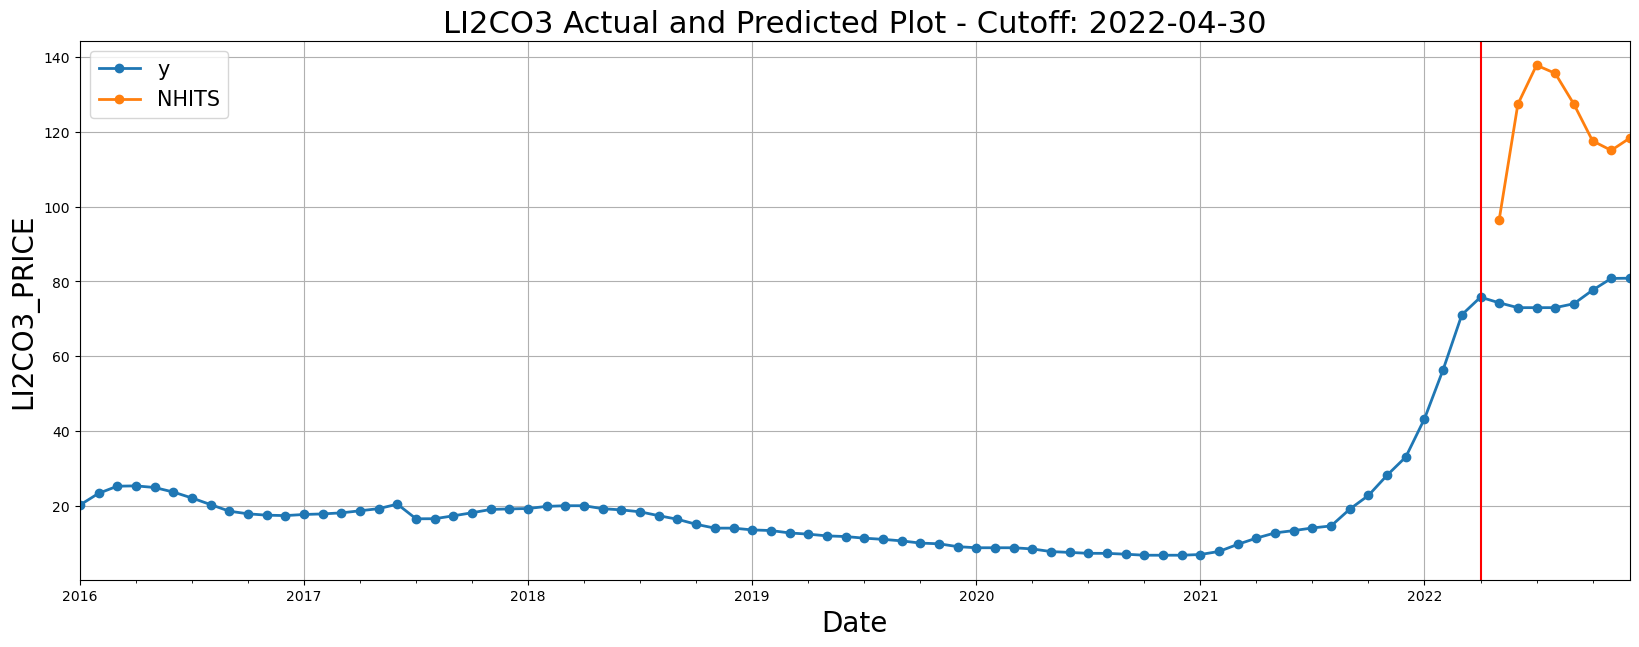

In [ ]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

# plot_df['NHITS_30'] = (plot_df['NHITS'] - 30).copy()
plot_df[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker='o')

plt.axvline(cutoff_date, color='red')
ax.set_title(f'LI2CO3 Actual and Predicted Plot - Cutoff: {cutoff_date}', fontsize=22)
ax.set_ylabel('LI2CO3_PRICE', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

# fig1.savefig(f'./data/forecasting_{cutoff_date}.png', dpi=100)
fig.savefig(f'./data/forecast_plot_{cutoff_date}_wv.png')

In [ ]:
plot_df

,unique_id,y,lioh_cif_fast_kg_spot_exchng,Baltic Dry Index (BDI),Howe Robinson Container Index,Shanghai Containerized Freight Index (SCFI),옥수수 For Grain [미국(생산자 가격)] 현물,원당 (daily) [ISA] 현물,대두 [미국(생산자 가격)] 현물,대두박 [파라나구아(FOB)] 현물,...,Pilbara Mineral Limited_price_Low,Pilbara Mineral Limited_price_Close,Pilbara Mineral Limited_price_Adj Close,Allkem Limited (AKE.AX)_price_Open,Allkem Limited (AKE.AX)_price_High,Allkem Limited (AKE.AX)_price_Low,Allkem Limited (AKE.AX)_price_Close,Allkem Limited (AKE.AX)_price_Adj Close,NBEATSx,NHITS
ds,,,,,,,,,,,,,,,,,,,,,
2016-01-31,A,20.177268,-0.237734,-1.302468,-0.644064,-0.195705,-0.461301,-0.468886,0.391356,-1.226492,...,-0.830830,-0.827825,-0.397665,-0.915916,-0.911882,-0.921663,-0.909069,-0.909069,NaN,NaN
2016-02-29,A,23.306868,-0.054803,-1.396112,-0.645288,-0.182527,-0.532459,-0.733272,0.138779,-1.332251,...,-0.752678,-0.750469,-0.397665,-0.910118,-0.915569,-0.908508,-0.916207,-0.916207,NaN,NaN
2016-03-31,A,25.223010,0.133909,-1.305967,-0.644523,-0.362815,-0.532459,-0.012903,0.099921,-1.436497,...,-0.733675,-0.731680,-0.397665,-0.833402,-0.834459,-0.834589,-0.834453,-0.834453,NaN,NaN
2016-04-30,A,25.308243,0.173425,-1.041598,-0.648195,-0.472294,-0.524553,-0.083130,-0.003701,-1.168180,...,-0.525438,-0.509230,-0.397665,-0.691659,-0.695181,-0.693237,-0.700107,-0.700107,NaN,NaN
2016-05-31,A,24.875099,0.107095,-1.026945,-0.645747,-0.487834,-0.445488,0.514051,-0.074941,0.104912,...,-0.391346,-0.377609,-0.397665,-0.497700,-0.494779,-0.496022,-0.493870,-0.493870,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,A,73.000000,2.420773,-0.092744,2.119559,2.773368,2.369193,0.793818,2.593314,1.844361,...,2.245839,2.264053,2.410643,2.144853,2.155770,2.181382,2.184215,2.184215,75.197159,135.706818
2022-09-30,A,74.047619,2.507937,-0.004062,1.188816,3.024986,2.250597,0.750690,1.621862,1.935267,...,2.084336,2.084871,1.970948,2.828439,2.823884,2.834908,2.836251,2.836251,76.052681,127.462090
2022-10-31,A,77.673913,2.664680,0.381286,0.204375,3.036207,1.784119,0.691518,1.427572,1.447594,...,2.354164,2.362142,2.222022,2.765597,2.782167,2.764528,2.761120,2.761120,78.720299,117.633171


In [ ]:
plot_df[['y', 'NHITS']].to_csv(f'./data/forecast_plot_{cutoff_date}_wv.csv',index=False)

In [ ]:
# pip install jupyterlab_widgets